-------------------------------------
# ECG Beat classification:
### Model - CNN

### Data Method - Patient hold-out

-------------------------------------

### Imports

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import seaborn as sns
from sklearn import *
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, LeakyReLU
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Activation
import itertools
import time
from sklearn.utils import resample
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

print("You are using Tensorflow version", tf.__version__)

print(tf.config.list_physical_devices('GPU'))

You are using Tensorflow version 2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# path = './drive/MyDrive/Colab_Notebooks/ECG_with_Expected_gradients/'
path = './'

In [4]:
os.listdir(path)

['CNN_holdout_patients_train_test.ipynb',
 'Data',
 'ECG',
 'eval_data_10k',
 'RAN_MODELS',
 'reserver_eval_data',
 'tryCNN_holdout_patients_IG_train_test.ipynb',
 'tryLSTM_leaveout_patients_EG_train_test.ipynb']

### Loading data

In [5]:
train_c1 = np.genfromtxt(path+'Data/train_beats_sc.csv', delimiter=',')
train_c0 = np.genfromtxt(path+'Data/train_beats_fc.csv', delimiter=',')
test_c1 = np.genfromtxt(path+'Data/test_beats_sc.csv', delimiter=',')
test_c0 = np.genfromtxt(path+'Data/test_beats_fc.csv', delimiter=',')

train_x_c01 = np.concatenate((train_c0[:, :-2], train_c1[:, :-2]), axis=1)
train_y_c01 = np.concatenate((train_c0[:, -2:], train_c1[:, -2:]), axis=1)

test_x_c01 = np.concatenate((test_c0[:, :-2], test_c1[:, :-2]), axis=1)
test_y_c01 = np.concatenate((test_c0[:, -2:], test_c0[:, -2:]), axis=1)

train_x = train_x_c01.reshape(-1, train_x_c01.shape[1], 1).astype('float32')
test_x = test_x_c01.reshape(-1, test_x_c01.shape[1], 1).astype('float32')

train_y = tf.keras.utils.to_categorical(train_y_c01[:,0])
test_y = tf.keras.utils.to_categorical(test_y_c01[:,0])

print("Train:")
print("x:", train_x.shape, "y:", train_y.shape)
print("Test")
print("x:", test_x.shape, "y:", test_y.shape)

Train:
x: (28984, 920, 1) y: (28984, 9)
Test
x: (27219, 920, 1) y: (27219, 9)


### Creating a performance metrics function

In [6]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score_macro = f1_score(test, pred, average='macro') 
    f1score_micro = f1_score(test, pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score macro : {}".format(f1score_macro))
    print("f1score micro : {}".format(f1score_micro))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score_macro,3), 
            round(f1score_micro, 3), cm)

### Function for building the CNN model

In [7]:
# Defining the model
verbose = 1
epochs = 10
batch_size = 50

opt = Adam(learning_rate=0.0001)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=2,
        min_lr=0.0001 * 0.0001)

def getCNNModel():
    
    input = keras.layers.Input(shape=(train_x.shape[1],train_x.shape[2]))
    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)

    #block 2

    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = keras.layers.Dropout(0.2)(x)

    #block 3
    for i in range(4):


        shortcut = MaxPooling1D(pool_size=1)(x)

        filters = 64 * ((i//2)+1)
        # print("Filter size = "+str(filters))
        x = keras.layers.Conv1D(kernel_size=16, filters=filters, strides=1, use_bias=True, padding="same", kernel_initializer='VarianceScaling')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU(alpha=0.3)(x)

        x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, padding="same", kernel_initializer='VarianceScaling')(x)

        x = keras.layers.LeakyReLU(alpha=0.3)(x)
        x = keras.layers.Dropout(0.2)(x)
    

        x = tf.keras.layers.Add()([x, shortcut])


    x = keras.layers.Conv1D(kernel_size=16, filters=32, strides=1, use_bias=True, kernel_initializer='VarianceScaling')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = keras.layers.Flatten()(x)
    out = keras.layers.Dense(9, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=[input], outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

### List of models

In [8]:
cnn1 = getCNNModel()
cnn2 = getCNNModel()
cnn3 = getCNNModel()
cnn4 = getCNNModel()
cnn5 = getCNNModel()
cnn6 = getCNNModel()
cnn7 = getCNNModel()
cnn8 = getCNNModel()
cnn9 = getCNNModel()
cnn10 = getCNNModel()

modellist = [cnn1, cnn2, cnn3, cnn4, cnn5, cnn6, cnn7, cnn8, cnn9, cnn10]

### Fitting all the models

In [9]:
modelhistory = []
for m in range(len(modellist)):
  print("*"*10,"Model",m+1,"*"*10)
  modelhistory.append(modellist[m].fit(train_x,train_y,epochs=epochs,batch_size=batch_size,validation_split=0.1,verbose=verbose, callbacks=[reduce_lr]))

********** Model 1 **********
Train on 26085 samples, validate on 2899 samples
Epoch 1/10
26085/26085 [==============================] - 26s 1ms/sample - loss: 0.2141 - accuracy: 0.9339 - val_loss: 0.1287 - val_accuracy: 0.9565
Epoch 2/10
26085/26085 [==============================] - 21s 816us/sample - loss: 0.0827 - accuracy: 0.9739 - val_loss: 0.0723 - val_accuracy: 0.9769
Epoch 3/10
26085/26085 [==============================] - 22s 831us/sample - loss: 0.0516 - accuracy: 0.9835 - val_loss: 0.0515 - val_accuracy: 0.9845
Epoch 4/10
26085/26085 [==============================] - 22s 829us/sample - loss: 0.0404 - accuracy: 0.9868 - val_loss: 0.0556 - val_accuracy: 0.9865
Epoch 5/10
26085/26085 [==============================] - 22s 832us/sample - loss: 0.0324 - accuracy: 0.9895 - val_loss: 0.0475 - val_accuracy: 0.9897
Epoch 6/10
26085/26085 [==============================] - 22s 831us/sample - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.0570 - val_accuracy: 0.9890
Epoch 7/10
26085/

### Model predictions

In [10]:
modelpreds = []
for m in range(len(modellist)):
  print("*"*10, "Model", m+1, "*"*10)
  modelpreds.append(np.argmax(modellist[m].predict(test_x, verbose=1),axis=1))

********** Model 1 **********
27219/27219 [==============================] - 7s 249us/sample
********** Model 2 **********
27219/27219 [==============================] - 7s 242us/sample
********** Model 3 **********
27219/27219 [==============================] - 7s 245us/sample
********** Model 4 **********
27219/27219 [==============================] - 7s 244us/sample
********** Model 5 **********
27219/27219 [==============================] - 7s 242us/sample
********** Model 6 **********
27219/27219 [==============================] - 6s 239us/sample
********** Model 7 **********
27219/27219 [==============================] - 6s 237us/sample
********** Model 8 **********
27219/27219 [==============================] - 7s 255us/sample
********** Model 9 **********
27219/27219 [==============================] - 6s 236us/sample
********** Model 10 **********
27219/27219 [==============================] - 6s 236us/sample


### Generating the metrics

In [11]:
results = []
cnn_actual_value=np.argmax(test_y,axis=1)
for p in range(len(modelpreds)):
  print("*"*10,"Model",p+1,"*"*10)
  results.append(showResults(cnn_actual_value, modelpreds[p],'CNN'+str(p)))

********** Model 1 **********
Accuracy  : 0.9729233256181344
Precision : 0.8756177792908136
Recall : 0.9723981742068124
f1score macro : 0.9150189083492142
f1score micro : 0.9729233256181344
********** Model 2 **********
Accuracy  : 0.941658400382086
Precision : 0.8027151651238343
Recall : 0.9649634155136311
f1score macro : 0.8497629876017896
f1score micro : 0.941658400382086
********** Model 3 **********
Accuracy  : 0.9603953120981668
Precision : 0.8299117307397563
Recall : 0.9697093010383817
f1score macro : 0.8778843544695054
f1score micro : 0.9603953120981668
********** Model 4 **********
Accuracy  : 0.9622690032697748
Precision : 0.8355381344276913
Recall : 0.9618930210214074
f1score macro : 0.8813138959788185
f1score micro : 0.9622690032697748
********** Model 5 **********
Accuracy  : 0.9596605312465557
Precision : 0.8353713007600225
Recall : 0.9657254336730319
f1score macro : 0.885845851474949
f1score micro : 0.9596605312465557
********** Model 6 **********
Accuracy  : 0.963077262

### Generating the confusion matrices

In [12]:
cms = []
for p in modelpreds:
  cms.append(confusion_matrix(cnn_actual_value, p, normalize='true'))

### Extracting model train and validation accuracy & losses.

In [13]:
modelosses = []
modeleval_losses = []
modelacc = []
modeleval_acc = []
for h in modelhistory:
  modelosses.append(h.history['loss'])
  modeleval_losses.append(h.history['val_loss'])
  modelacc.append(h.history['accuracy'])
  modeleval_acc.append(h.history['val_accuracy'])
modelosses = np.array(modelosses)
modeleval_losses = np.array(modeleval_losses)
modelacc = np.array(modelacc)
modeleval_acc = np.array(modeleval_acc)
# losses , eval_losses, accuracy, eval_accuracy
history = np.array([modelosses, modeleval_losses, modelacc, modeleval_acc])

### Saving the data

In [14]:
# Saving data LSTM patient leavout
new_path = path+"eval_data_10k/cnn_ph/"

modelpreds = np.array(modelpreds)
results = np.array(results)
cms = np.array(cms)
# modelhistory = np.array(modelhistory)
np.save(new_path+"cnn_modelpreds.npy", modelpreds)
np.save(new_path+"cnn_results.npy", results)
np.save(new_path+"cnn_cms.npy", cms)
np.save(new_path+"cnn_history.npy", history)


C:\Users\podda\anaconda3\envs\ecg\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


Visualising the Mean Confusion Matrix

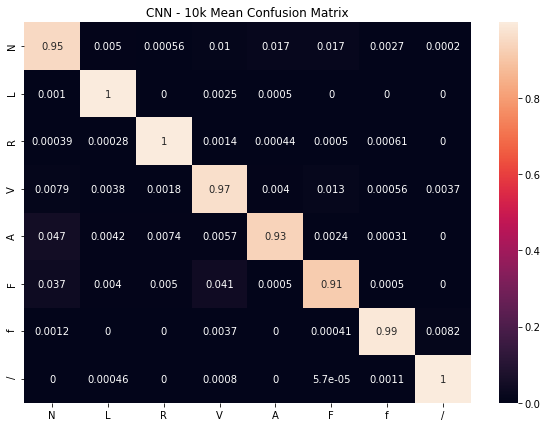

In [15]:
categories=['N','L','R','V','A','F','f','/']
cm = np.mean(cms, axis=0)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)
plt.title('CNN - 10k Mean Confusion Matrix')
# plt.savefig("lstm_mean_cm_pl.png", dpi=300)
plt.show()

### Mean Metrics

In [16]:
metrics = ["Accuracy", "Precision", "Recall", "f1-score macro", "f1-score micro"]
mean_metrics = np.mean(results[:,1:6], axis=0)
for i in range(len(mean_metrics)):
  print(metrics[i],":",mean_metrics[i])

Accuracy : 0.9586
Precision : 0.8320000000000001
Recall : 0.9667999999999999
f1-score macro : 0.8795
f1-score micro : 0.9586


### Mesn CNN Loss vs Accuracy Plot

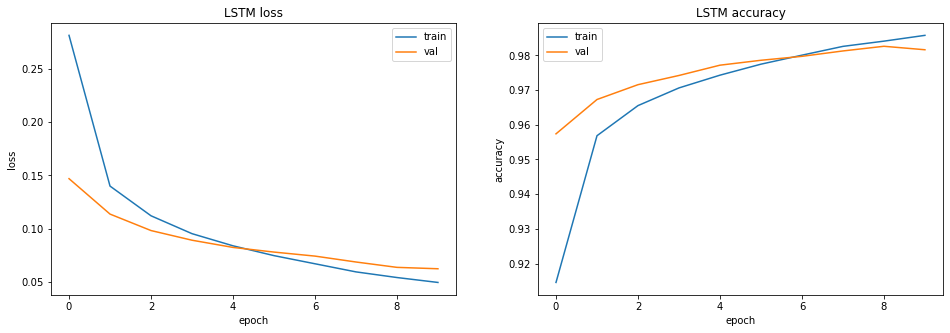

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax[0].plot(np.mean(modelosses, axis=0))
ax[0].plot(np.mean(modeleval_losses, axis=0))
ax[0].set_title('LSTM loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper right')
ax[1].plot(np.mean(modelacc,axis=0))
ax[1].plot(np.mean(modeleval_acc, axis=0))
ax[1].set_title('LSTM accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()
# fig.savefig('lstm_leaveout_patients_loss_and_accuracy.jpg')